In [2]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
plt.style.use ('ggplot')
import seaborn as sns
%matplotlib inline
sns.set_style(style="whitegrid")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from bs4 import BeautifulSoup

import nltk, string, contractions

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

from operator import itemgetter

In [3]:
df = pd.read_csv('data/modeling_ready_microwave1')

In [4]:
df.review_date = pd.to_datetime(df.review_date)

In [5]:
def remove_punctuations(text):
    punct =[]
    punct += list(string.punctuation)
    punct += '’'
    punct.remove("'")
    for punctuation in punct:
        text = text.replace(punctuation, ' ')
    return text

In [28]:
keep_words = ['not', 'ain', 'aren', "aren't", 'couldn', "couldn't", 
              'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
              'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
              'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
              "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
              'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
              'wouldn', "wouldn't", 'fire', 'off']
test_stop_words = ['great', 'excellent', '1', '2', 'feature', 'nice', 'old']
review_stop_words = ['panasonic', 'really', 'husband', 'thanks', 'thank', 'ha', 
              'just', 'thing', 'did', 'nn', 'wa', 'yr', 'u', 'say', 'doe',
              'mom', 'christmas', 'gift', 'got', 'way', 'le', 'daughter',
              'e','not','love','good','bought','great microwave','micro',
              'great oven','microwave','product','work great','nice work',
              'work great use','work great love','feature work great',
              'unit work great','oven work great','easy use love','old oven',
              'old old','20 year old','unit', 'not', 'work', 'amazon', 'com',
              'old', 'wife', 'highly', 'recommend', 'like', 'charm', '20', 
              'easy', 'oven', 'use', 'year', 'lot', 'pleased', 'happy', 'hope']
for _ in text.ENGLISH_STOP_WORDS:
    if _ in keep_words:
        pass
    else:
        review_stop_words.append(_)
for _ in test_stop_words:
    review_stop_words.append(_)

In [36]:
def nlp_prep(df):
    # lowercase everything
    # get rid of '\n' from whitespace
    # regex remove hyperlinks
    # remove punctuation
    # remove ' s ' from removing punctuation
    
    # lowercase everything
    df['model_ready'] = df['clean_review'].apply(lambda x: x.lower())
    # expand contractions
    df['model_ready'] = df['model_ready'].apply(lambda x:[contractions.fix(word) for word in x.split()])
    df['model_ready'] = [' '.join(map(str, l)) for l in df['model_ready']]
    # get rid of '\n' from whitespace 
    df['model_ready'] = df['model_ready'].apply(lambda x: x.replace('\n', ' '))
    # regex remove hyperlinks
    df['model_ready'] = df['model_ready'].str.replace('http\S+|www.\S+', '', case=False)
    # remove punctuations
    df['model_ready'] = df['model_ready'].apply(remove_punctuations)
    # remove ' s ' that was created after removing punctuations
    df['model_ready'] = df['model_ready'].apply(lambda x: str(x).replace(" s ", " "))
    # remove stop words
    df['model_ready'] = df['model_ready'].apply(lambda x: ' '.join([word for word in x.split() if word not in (review_stop_words)]))
    return df

In [37]:
nlp_prep(df)

,customer_id,review_id,product_id,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date,review_wordcount,clean_review,model_ready,token
0,44300577,R2ZU11YALTJNZX,B0009KMYHI,1.0,0.0,0.0,Y,I have had this microwave for just over 3 year...,I have had this microwave for just over 3 year...,2015-08-31,91,I have had this microwave for just over 3 year...,3 years door close does know door closed turn ...,"[i, have, had, this, microwave, for, just, ove..."
1,50952586,RVBITZNBVJ8AI,B0009KMYHI,5.0,0.0,0.0,Y,It takes a good bit of room on the counter,Man this thing cooks evenly and fast! It takes...,2015-08-30,23,Man this thing cooks evenly and fast! It takes...,man cooks evenly fast takes bit room counter r...,"[man, this, thing, cooks, evenly, and, fast, i..."
2,31144708,R44LZL0OR5EWP,B0009KMYDM,5.0,0.0,0.0,Y,Five Stars,Works great! Have had it over a year and no su...,2015-08-30,17,Works great! Have had it over a year and no su...,works surprises large,"[works, great, have, had, it, over, a, year, a..."
3,14667788,RPWWYNUD9X64U,B0009KMYHI,5.0,0.0,0.0,Y,... received this several years ago and it sti...,I ordered and received this several years ago ...,2015-08-29,13,I ordered and received this several years ago ...,ordered received years ago works,"[i, ordered, and, received, this, several, yea..."
4,25468208,RS76DCCGM685B,B0009KMYGY,1.0,3.0,3.0,Y,Avoid Panasonic - Doors Don't Close,I have had this microwave for just over 2 year...,2015-08-28,131,I have had this microwave for just over 2 year...,years door close does know door closed turn go...,"[i, have, had, this, microwave, for, just, ove..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,33705501,R34GY91QSWWUE4,B0009KMYGY,4.0,60.0,64.0,N,Just right for me...,The Panasonic NN-H765WF was exactly what I was...,2006-03-23,74,The Panasonic NN-H765WF was exactly what I was...,h765wf exactly looking wanted white match appl...,"[the, panasonic, nn, h765wf, was, exactly, wha..."
1871,39268146,R7N1LRCV8GU6L,B0009KMYHI,5.0,5.0,10.0,Y,good looking-good cooking,this microwave cooks food very evenly-no need ...,2006-03-19,21,this microwave cooks food very evenly-no need ...,cooks food evenly need stir think best looking...,"[this, microwave, cooks, food, very, evenly, n..."
1872,19314267,R15KWS9QSI7URC,B0009KMYDM,5.0,12.0,13.0,Y,Panasonic NN-H965WF Luxury full-size 2.2 cu.ft...,"its a great microwave , i use it every day , i...",2006-03-16,67,"its a great microwave , i use it every day , i...",day large fits heats evenly unlike microwaves ...,"[its, a, great, microwave, i, use, it, every, ..."
1873,11400155,RK5HSUM1GNRH8,B0009KMYDM,5.0,4.0,9.0,N,Panasonic Microwave Oven NN-965WF,Have had it for only a short time but it has p...,2006-02-24,20,Have had it for only a short time but it has p...,short time performed flawlessly far purchase,"[have, had, it, for, only, a, short, time, but..."


In [49]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [50]:
keep_words = ['not', 'ain', 'aren', "aren't", 'couldn', "couldn't", 
              'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 
              'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
              'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
              "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 
              'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
              'wouldn', "wouldn't", 'fire', 'off']

In [51]:
test_stop_words = ['great', 'excellent', '1', '2', 'feature', 'nice', 'old']
review_stop_words = ['panasonic', 'really', 'husband', 'thanks', 'thank', 'ha', 
              'just', 'thing', 'did', 'nn', 'wa', 'yr', 'u', 'say', 'doe',
              'mom', 'christmas', 'gift', 'got', 'way', 'le', 'daughter',
              'e','not','love','good','bought','great microwave','micro',
              'great oven','microwave','product','work great','nice work',
              'work great use','work great love','feature work great',
              'unit work great','oven work great','easy use love','old oven',
              'old old','20 year old','unit', 'not', 'work', 'amazon', 'com',
              'old', 'wife', 'highly', 'recommend', 'like', 'charm', '20', 
              'easy', 'oven', 'use', 'year', 'lot', 'pleased', 'happy', 'hope']
for _ in text.ENGLISH_STOP_WORDS:
    if _ in keep_words:
        pass
    else:
        review_stop_words.append(_)
for _ in test_stop_words:
    review_stop_words.append(_)

In [52]:
def vectorize_this(max_features, min_df, max_df, ngram_max):
    vectorizer = TfidfVectorizer(tokenizer = lemmatize_text,
                             stop_words= review_stop_words,
                             max_features = max_features,
                             min_df = min_df,
                             max_df =  max_df,
                             ngram_range=(0, ngram_max)
                            )
    X = df['model_ready']
    X = vectorizer.fit_transform(X)
    return X, vectorizer

In [53]:
X, vectorizer = vectorize_this(10000, 4, .8, 1)

In [54]:
X

<1875x1794 sparse matrix of type '<class 'numpy.float64'>'
	with 39757 stored elements in Compressed Sparse Row format>

In [55]:
def make_nmf(n_components, alpha, X):
    nmf = NMF(
            n_components=n_components,
            init='nndsvd',
            random_state=12345,
            alpha = alpha
            ).fit(X)

    W = nmf.fit_transform(X)
    H = nmf.components_
    return nmf, W, H

In [56]:
nmf, W, H, = make_nmf(17, .1, X)

In [57]:
def topic_keywords(vectorizer=vectorizer, lda_model=nmf, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [58]:
topic_keywords = topic_keywords(vectorizer=vectorizer, lda_model=nmf, n_words=10)        

In [59]:
def topic_featuring(n_components=17, n_words=10):
    
    nmf, W, H = make_nmf(n_components, .1, X)
    
    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    Topics_theme = range(n_components)
    df_topic_keywords['topic_theme'] = Topics_theme
    df_topic_keywords.set_index('topic_theme', inplace=True)
    return df_topic_keywords.T

In [60]:
df

,customer_id,review_id,product_id,star_rating,helpful_votes,total_votes,verified_purchase,review_headline,review_body,review_date,review_wordcount,clean_review,model_ready,token
0,44300577,R2ZU11YALTJNZX,B0009KMYHI,1.0,0.0,0.0,Y,I have had this microwave for just over 3 year...,I have had this microwave for just over 3 year...,2015-08-31,91,I have had this microwave for just over 3 year...,3 years door close does know door closed turn ...,"[3, years, door, close, does, know, door, clos..."
1,50952586,RVBITZNBVJ8AI,B0009KMYHI,5.0,0.0,0.0,Y,It takes a good bit of room on the counter,Man this thing cooks evenly and fast! It takes...,2015-08-30,23,Man this thing cooks evenly and fast! It takes...,man cooks evenly fast takes bit room counter r...,"[man, cooks, evenly, fast, takes, bit, room, c..."
2,31144708,R44LZL0OR5EWP,B0009KMYDM,5.0,0.0,0.0,Y,Five Stars,Works great! Have had it over a year and no su...,2015-08-30,17,Works great! Have had it over a year and no su...,works surprises large,"[works, surprises, large]"
3,14667788,RPWWYNUD9X64U,B0009KMYHI,5.0,0.0,0.0,Y,... received this several years ago and it sti...,I ordered and received this several years ago ...,2015-08-29,13,I ordered and received this several years ago ...,ordered received years ago works,"[ordered, received, years, ago, works]"
4,25468208,RS76DCCGM685B,B0009KMYGY,1.0,3.0,3.0,Y,Avoid Panasonic - Doors Don't Close,I have had this microwave for just over 2 year...,2015-08-28,131,I have had this microwave for just over 2 year...,years door close does know door closed turn go...,"[years, door, close, does, know, door, closed,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1870,33705501,R34GY91QSWWUE4,B0009KMYGY,4.0,60.0,64.0,N,Just right for me...,The Panasonic NN-H765WF was exactly what I was...,2006-03-23,74,The Panasonic NN-H765WF was exactly what I was...,h765wf exactly looking wanted white match appl...,"[h765wf, exactly, looking, wanted, white, matc..."
1871,39268146,R7N1LRCV8GU6L,B0009KMYHI,5.0,5.0,10.0,Y,good looking-good cooking,this microwave cooks food very evenly-no need ...,2006-03-19,21,this microwave cooks food very evenly-no need ...,cooks food evenly need stir think best looking...,"[cooks, food, evenly, need, stir, think, best,..."
1872,19314267,R15KWS9QSI7URC,B0009KMYDM,5.0,12.0,13.0,Y,Panasonic NN-H965WF Luxury full-size 2.2 cu.ft...,"its a great microwave , i use it every day , i...",2006-03-16,67,"its a great microwave , i use it every day , i...",day large fits heats evenly unlike microwaves ...,"[day, large, fits, heats, evenly, unlike, micr..."
1873,11400155,RK5HSUM1GNRH8,B0009KMYDM,5.0,4.0,9.0,N,Panasonic Microwave Oven NN-965WF,Have had it for only a short time but it has p...,2006-02-24,20,Have had it for only a short time but it has p...,short time performed flawlessly far purchase,"[short, time, performed, flawlessly, far, purc..."


In [61]:
df['token'] = df['model_ready'].apply(nltk.word_tokenize)

In [71]:
def topic_modeler(max_features=5000, min_df=2, max_df=.85, topic_max = 20, topic_step = 1):
    # Use Gensim's NMF to get the best num of topics via coherence score
    texts = df['token']

    # Create a dictionary
    # In gensim a dictionary is a mapping between words and their integer id
    dictionary = Dictionary(texts)

    # Filter out extremes to limit the number of features
    dictionary.filter_extremes(
        no_below=min_df,
        no_above=max_df,
        keep_n=max_features
    )

    # Create the bag-of-words format (list of (token_id, token_count))
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Create a list of the topic numbers we want to try
    topic_nums = list(np.arange(1, topic_max + 1, topic_step))

    # Run the nmf model and calculate the coherence score
    # for each number of topics
    coherence_scores = []

    for num in topic_nums:
        gs_nmf = Nmf(
            corpus=corpus,
            num_topics=num,
            id2word=dictionary,
            chunksize=2000,
            passes=5,
            kappa=.1,
            minimum_probability=0.01,
            w_max_iter=300,
            w_stop_condition=0.0001,
            h_max_iter=100,
            h_stop_condition=0.001,
            eval_every=10,
            normalize=True,
            random_state=12345
        )

        # Run the coherence model to get the score
        cm = CoherenceModel(
            model=gs_nmf,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_scores.append(round(cm.get_coherence(), 5))

    # Get the number of topics with the highest coherence score
    scores = list(zip(topic_nums, coherence_scores))
    best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]
    
#     if len(coherence_scores) == topic_max:
    fig, ax = plt.subplots(figsize=(14,8))
    plt.xlabel('Model Params: max_features = '+str(max_features)+',    min_df '+str(min_df)
               +',    max_df '+str(max_df))
    plt.ylabel('Coherence Score')
    plt.plot(range(0,topic_max), coherence_scores)
    plt.xticks(np.arange(0, topic_max, step=1))
    plt.yticks(np.arange(.37,.5,step=.01))
    plt.show()

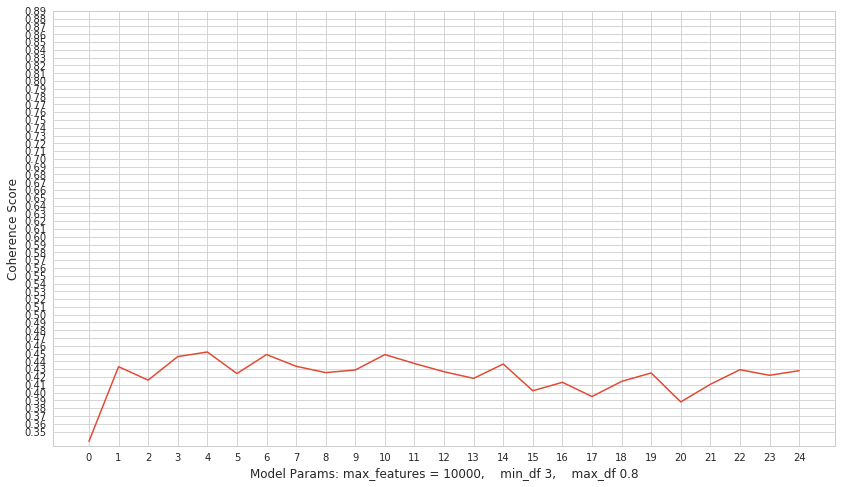

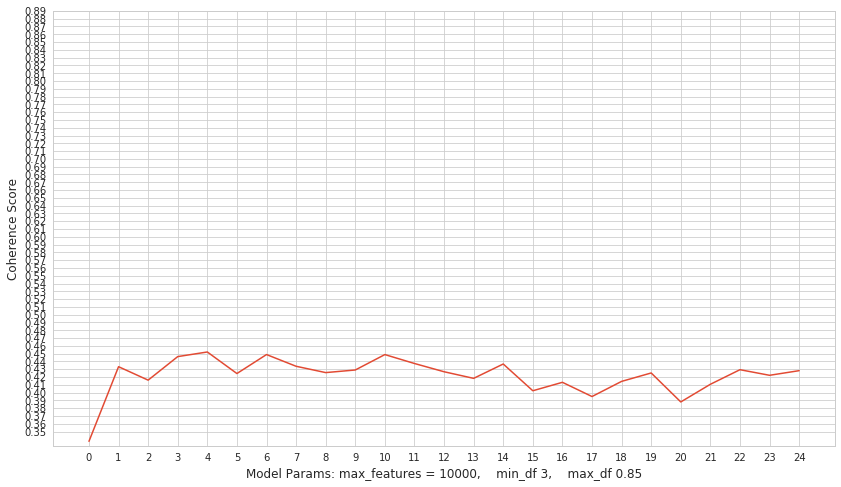

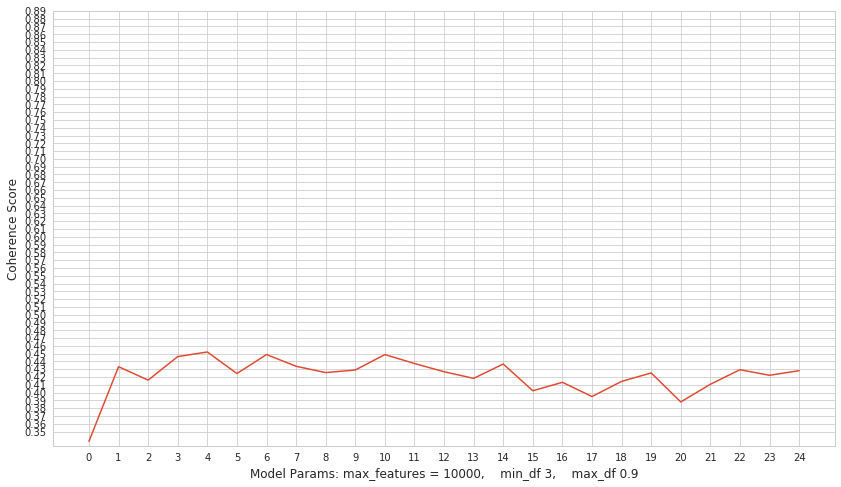

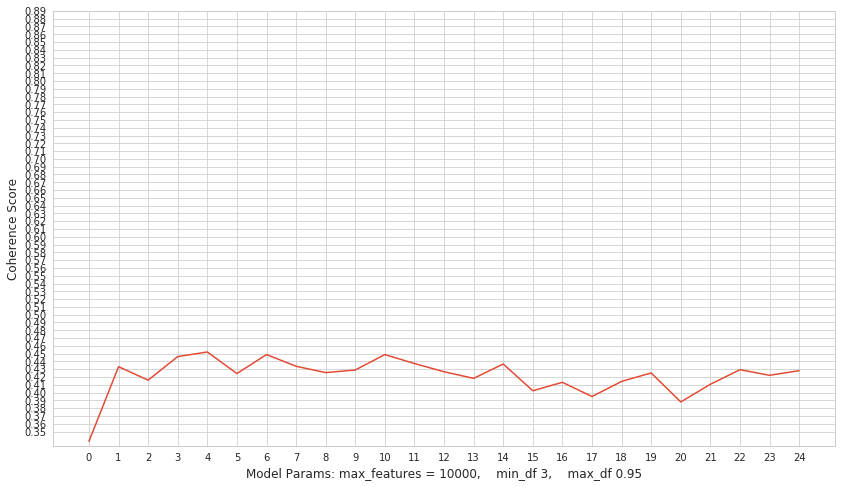

In [65]:
topic_modeler(10000, 3,.8,25, 1)
topic_modeler(10000, 3,.85,25, 1)
topic_modeler(10000, 3,.9,25, 1)
topic_modeler(10000, 3,.95,25, 1)

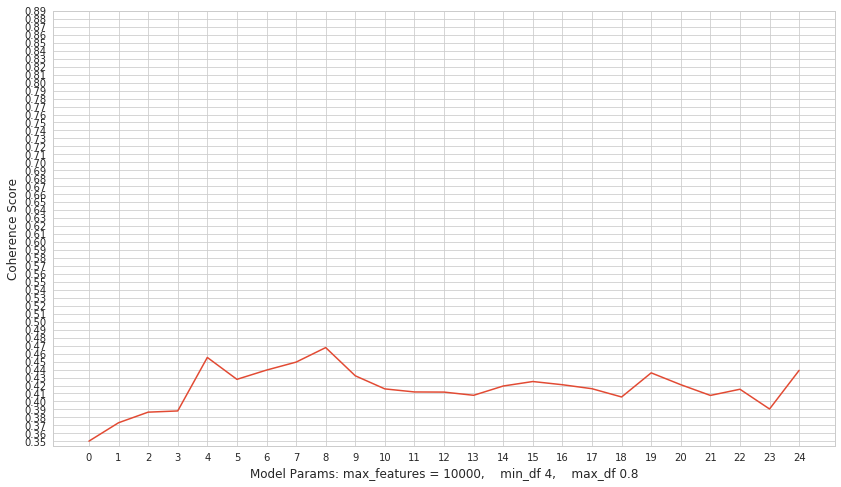

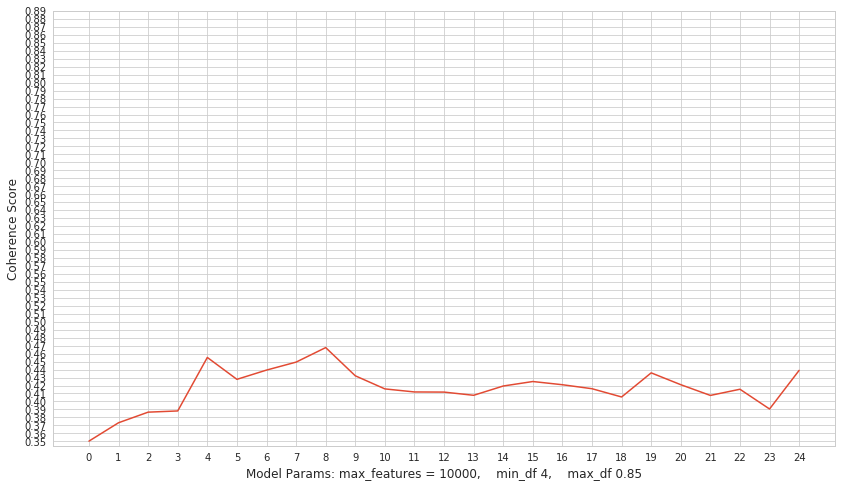

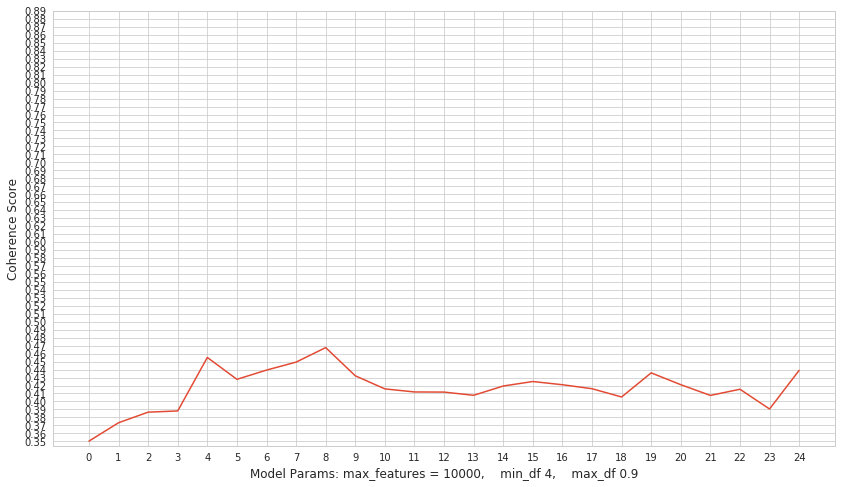

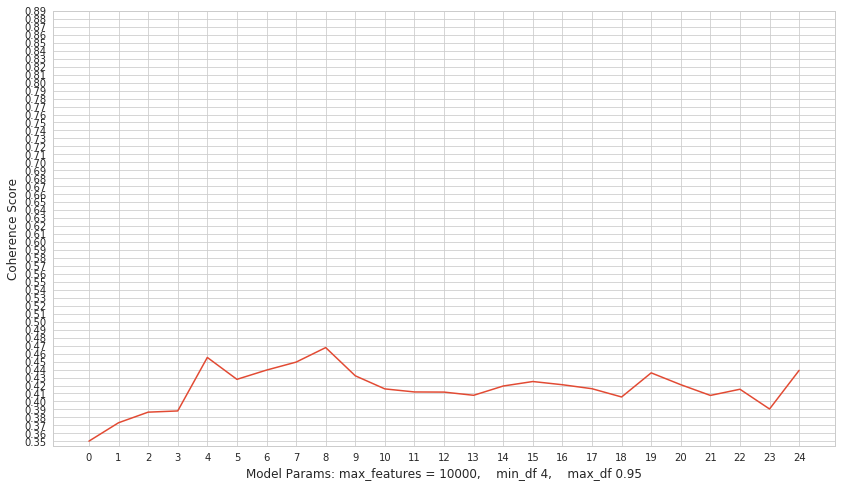

In [66]:
topic_modeler(10000, 4,.8,25, 1)
topic_modeler(10000, 4,.85,25, 1)
topic_modeler(10000, 4,.9,25, 1)
topic_modeler(10000, 4,.95,25, 1)

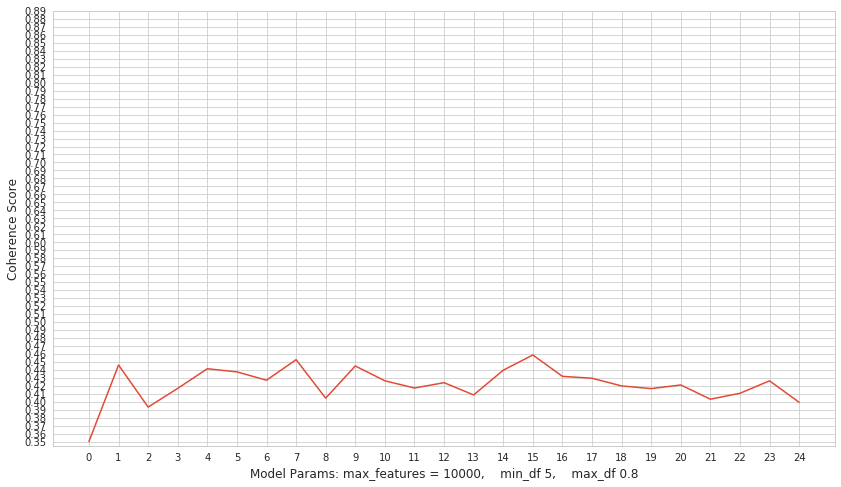

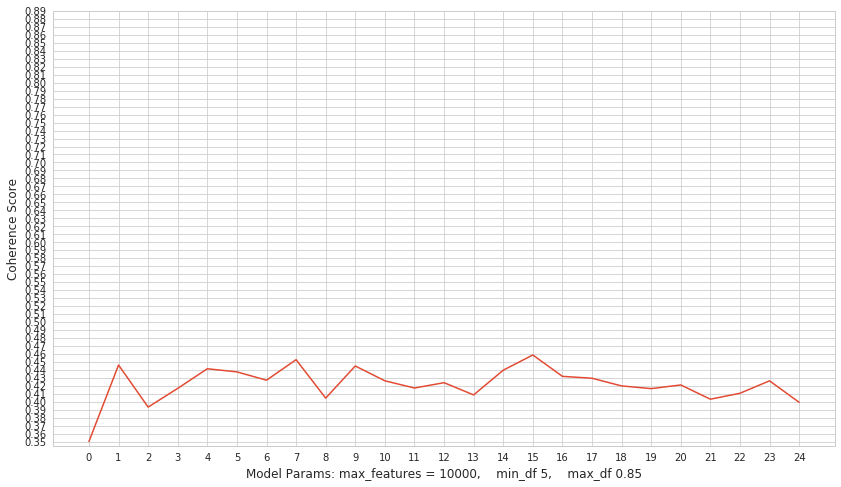

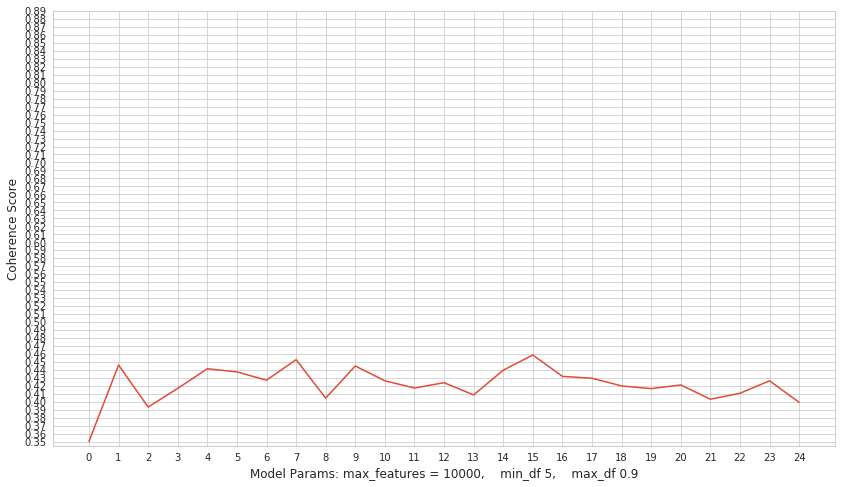

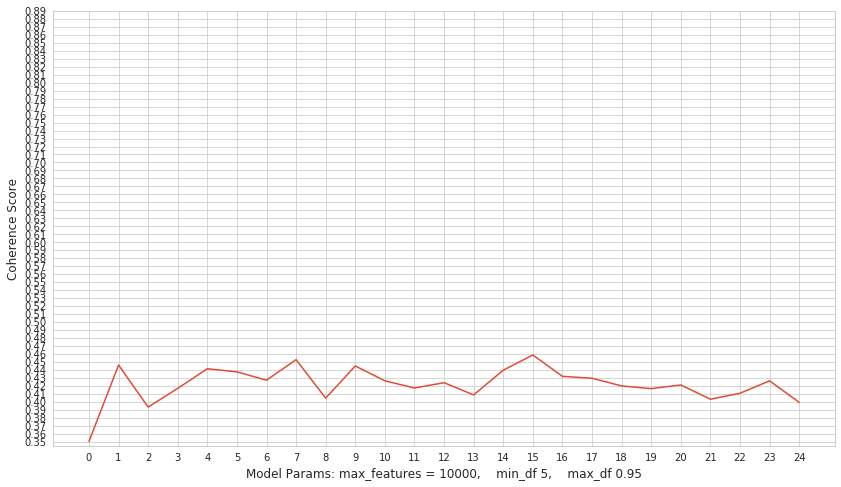

In [67]:
topic_modeler(10000, 5,.8,25, 1)
topic_modeler(10000, 5,.85,25, 1)
topic_modeler(10000, 5,.9,25, 1)
topic_modeler(10000, 5,.95,25, 1)

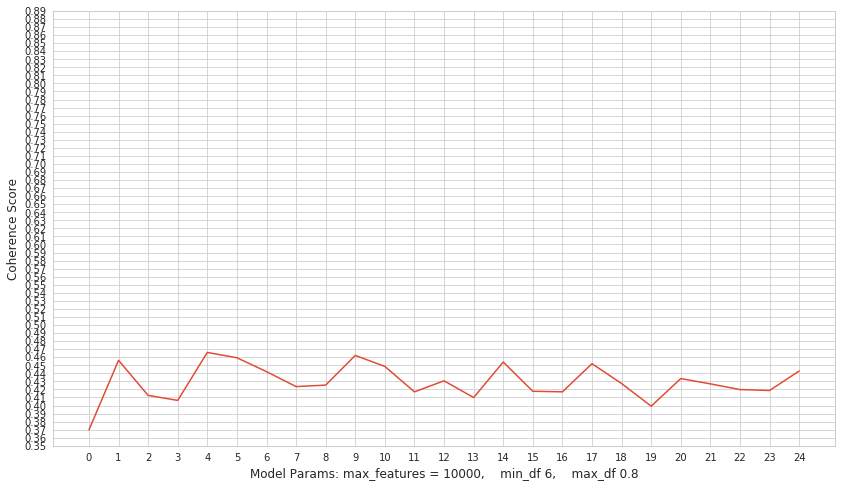

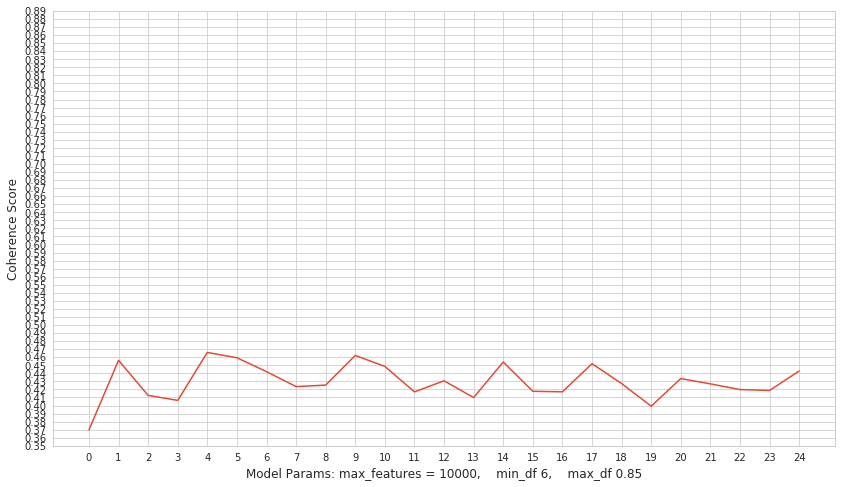

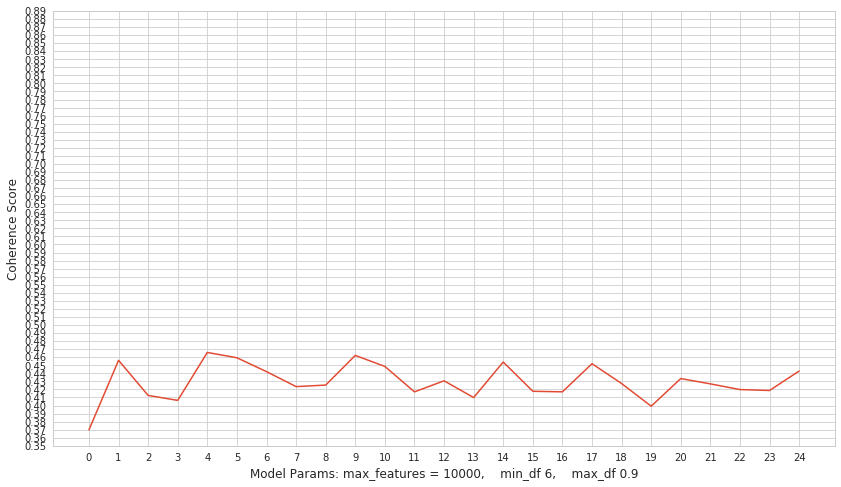

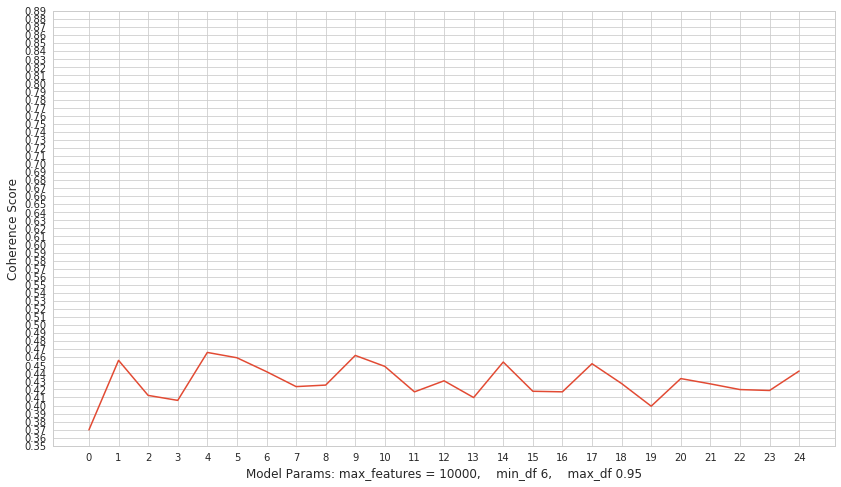

In [68]:
topic_modeler(10000, 6,.8,25, 1)
topic_modeler(10000, 6,.85,25, 1)
topic_modeler(10000, 6,.9,25, 1)
topic_modeler(10000, 6,.95,25, 1)

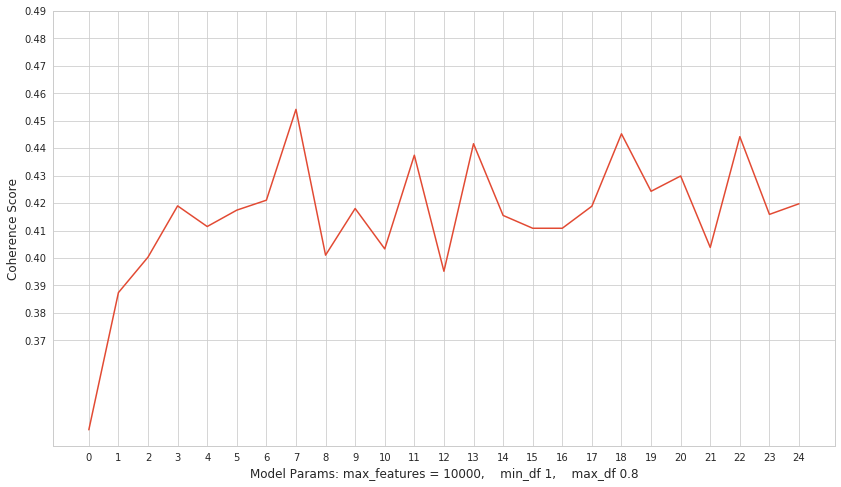

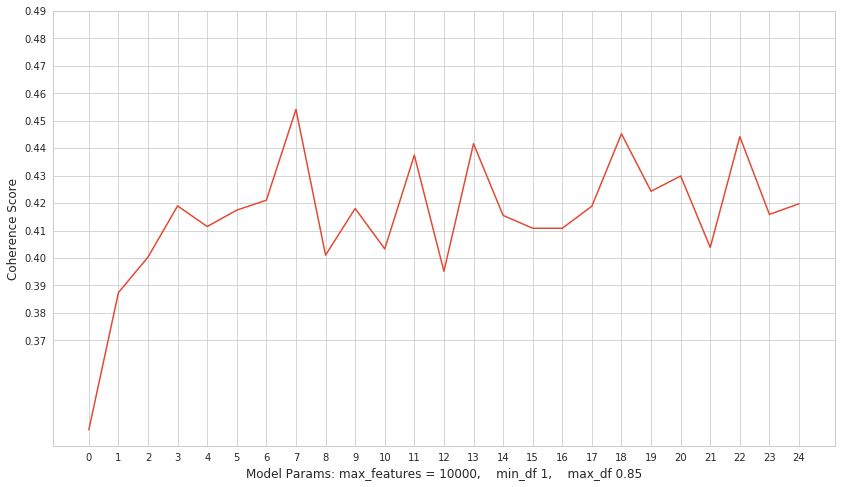

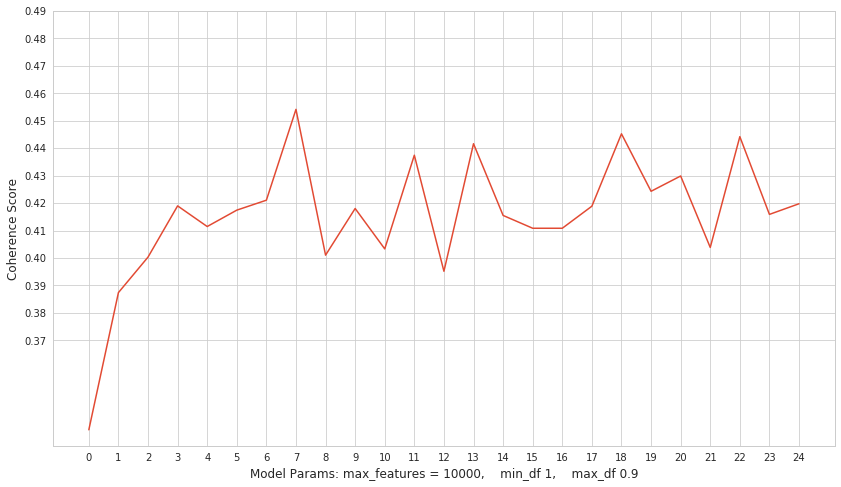

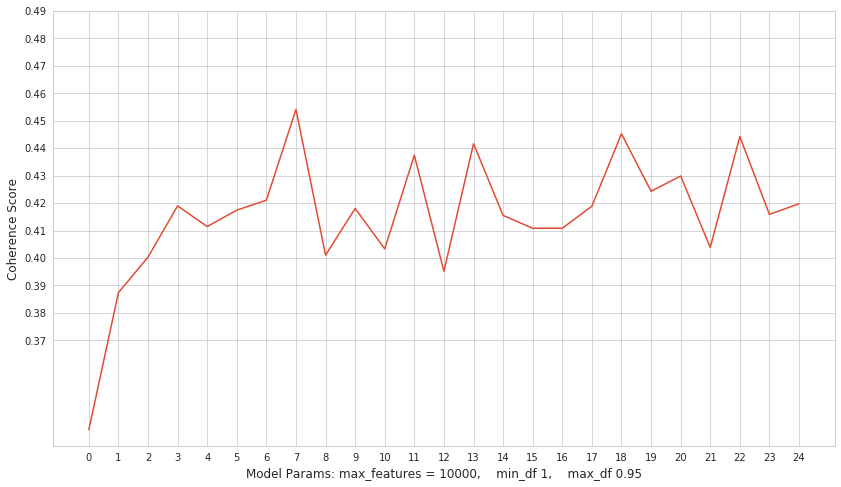

In [73]:
topic_modeler(10000, 1,.8,25, 1)
topic_modeler(10000, 1,.85,25, 1)
topic_modeler(10000, 1,.9,25, 1)
topic_modeler(10000, 1,.95,25, 1)

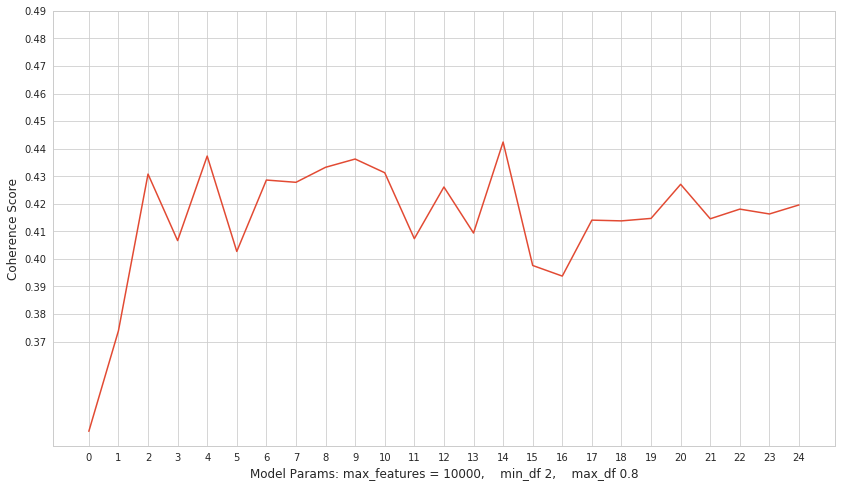

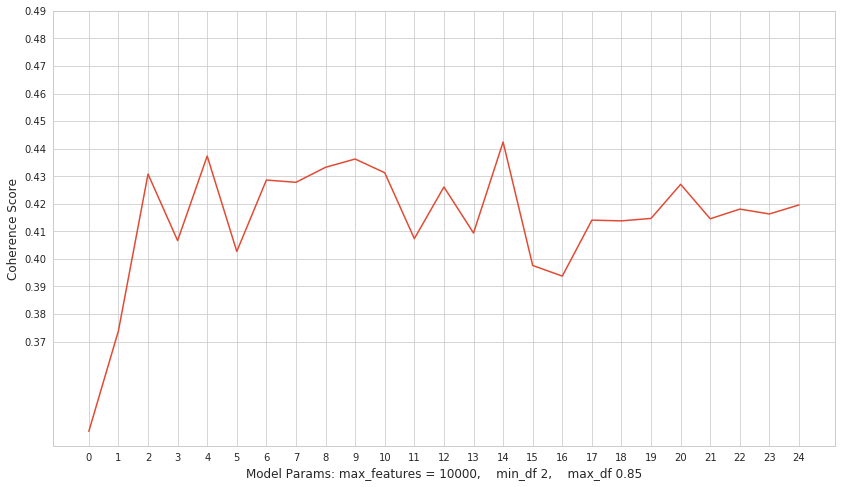

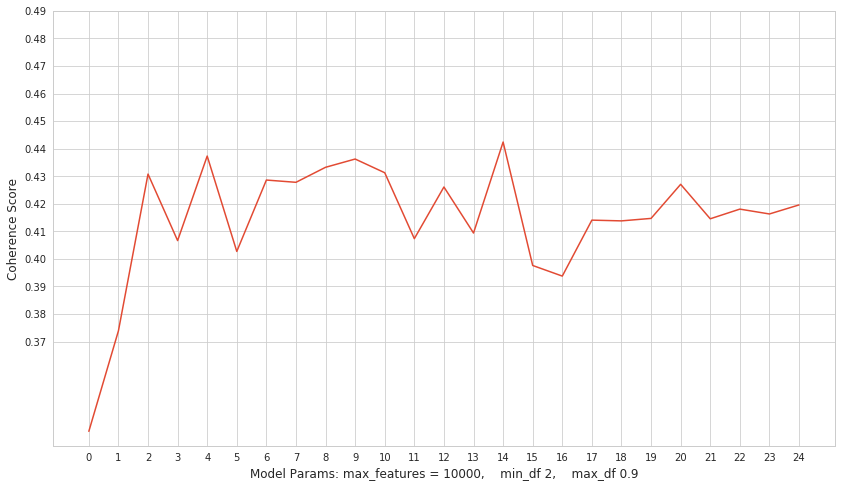

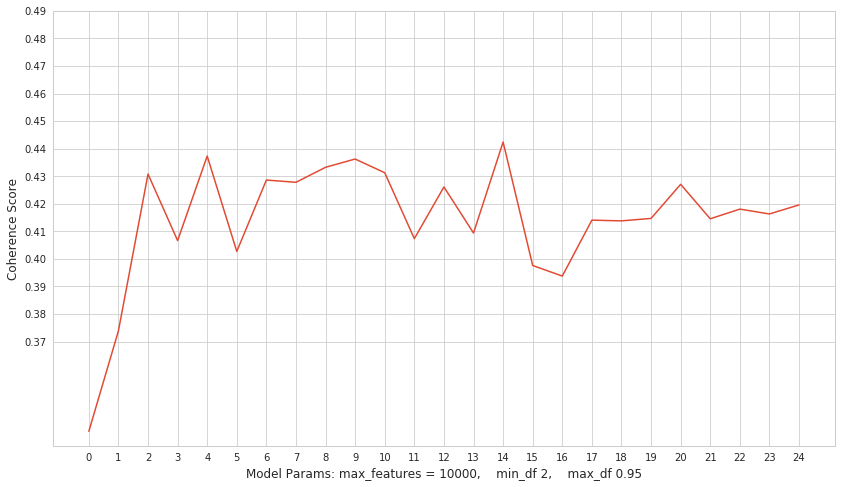

In [74]:
topic_modeler(10000, 2,.8,25, 1)
topic_modeler(10000, 2,.85,25, 1)
topic_modeler(10000, 2,.9,25, 1)
topic_modeler(10000, 2,.95,25, 1)

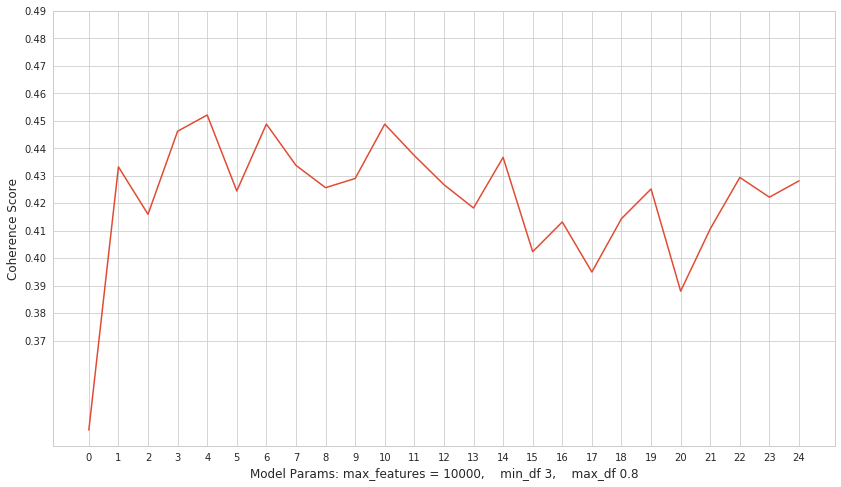

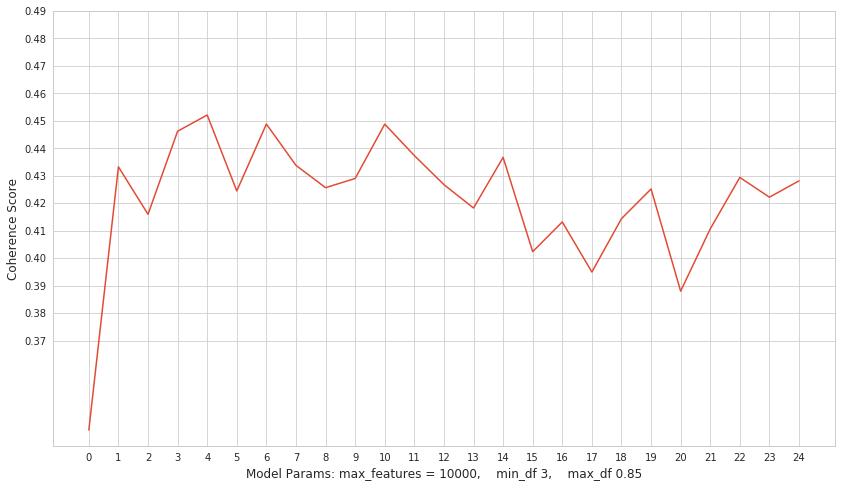

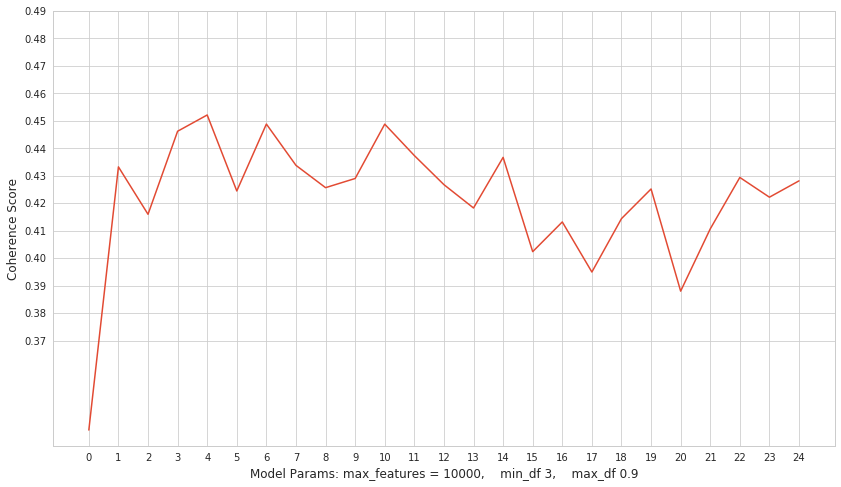

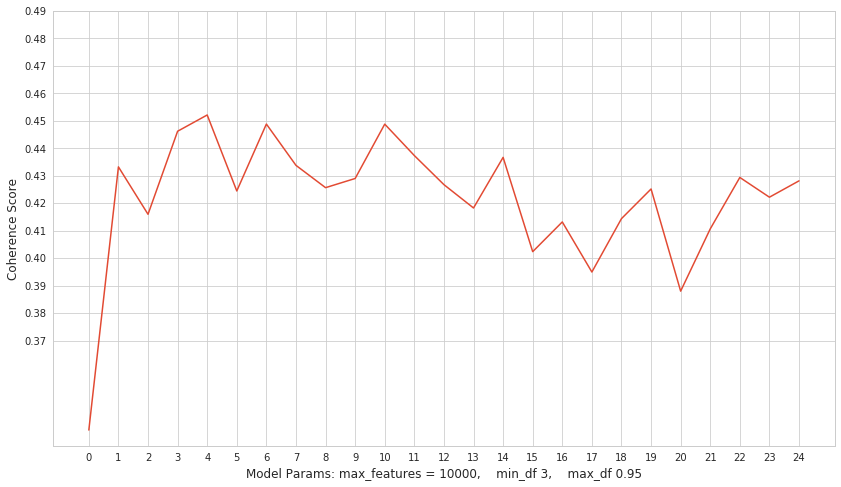

In [75]:
topic_modeler(10000, 3,.8,25, 1)
topic_modeler(10000, 3,.85,25, 1)
topic_modeler(10000, 3,.9,25, 1)
topic_modeler(10000, 3,.95,25, 1)

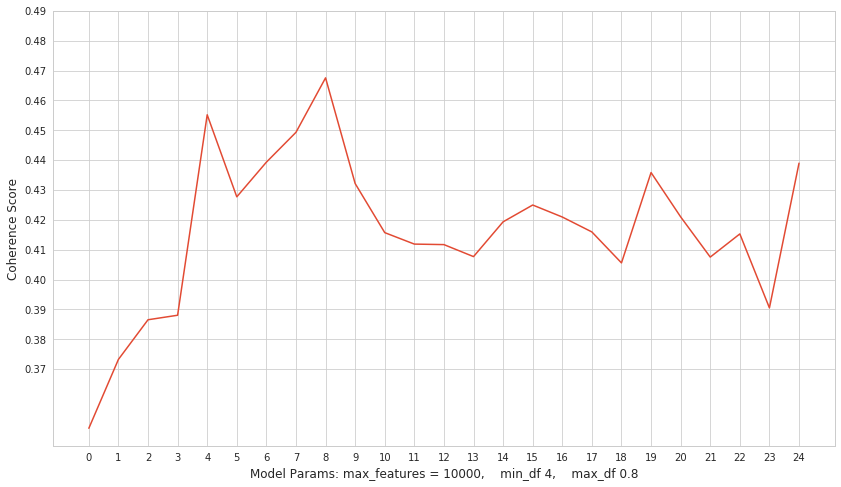

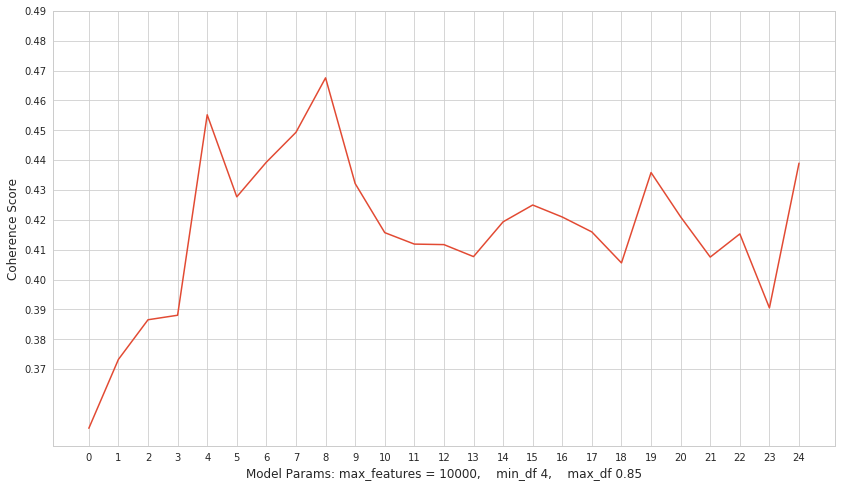

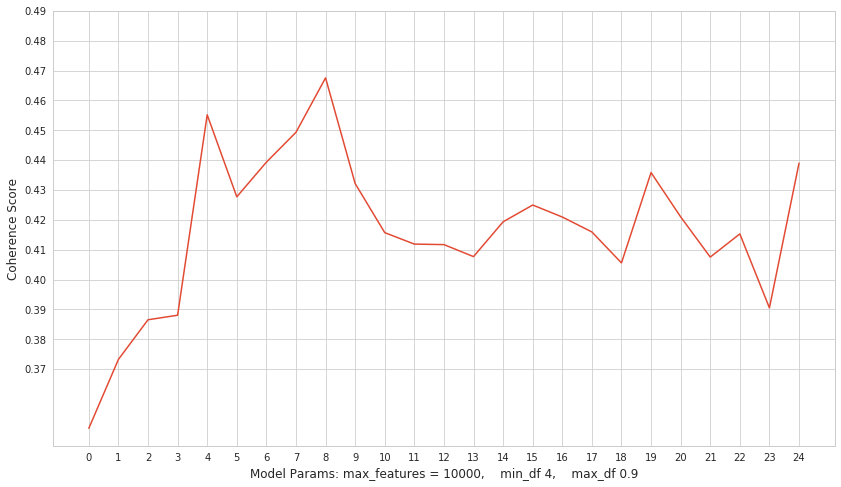

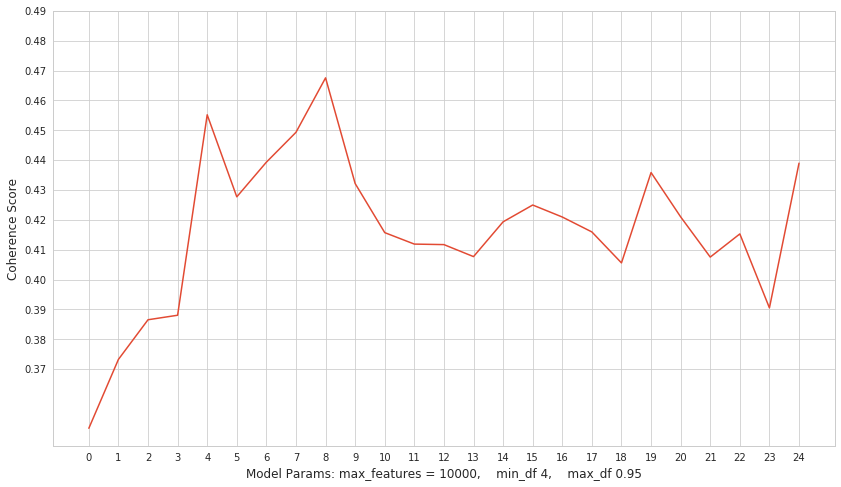

In [76]:
topic_modeler(10000, 4,.8,25, 1)
topic_modeler(10000, 4,.85,25, 1)
topic_modeler(10000, 4,.9,25, 1)
topic_modeler(10000, 4,.95,25, 1)

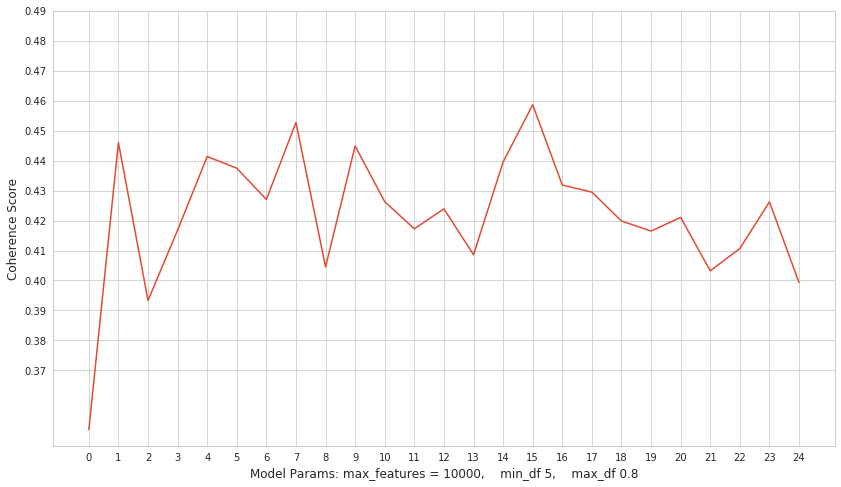

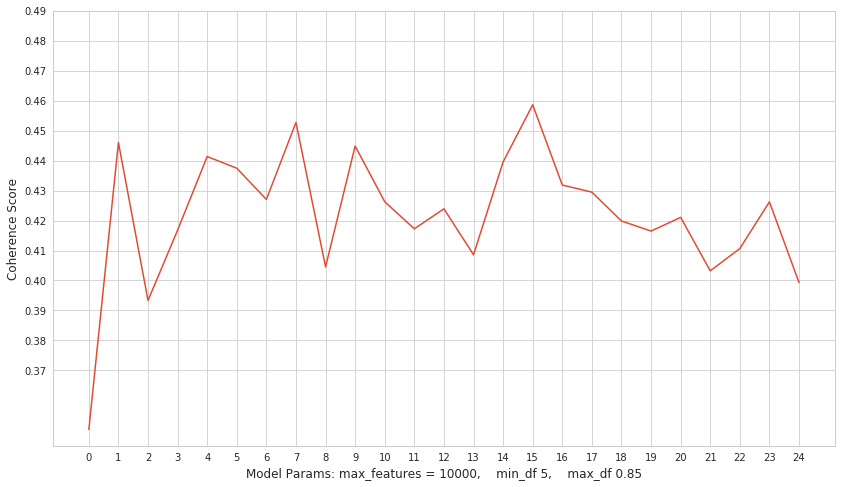

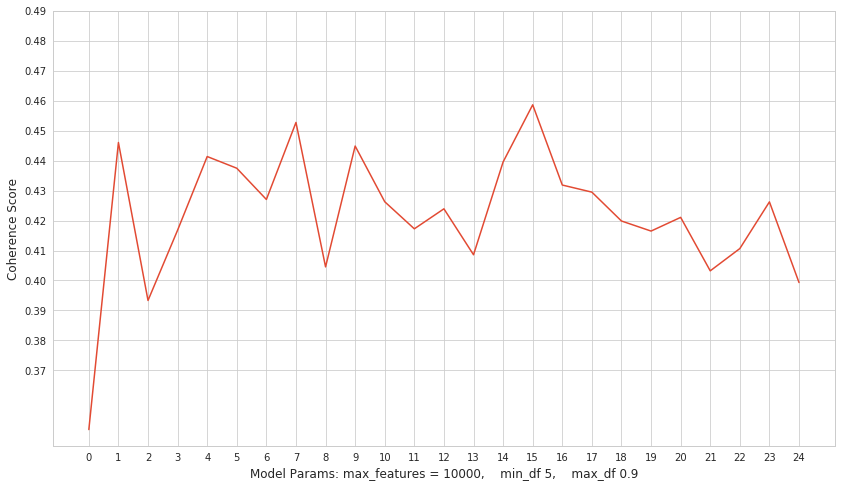

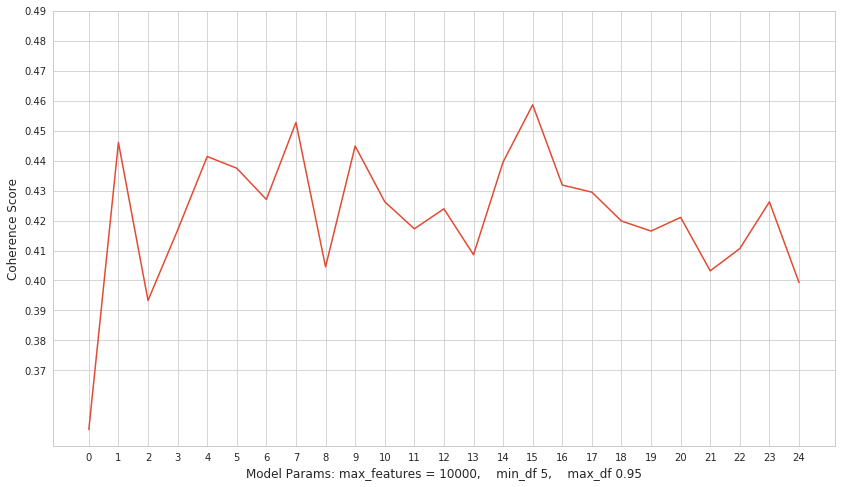

In [77]:
topic_modeler(10000, 5,.8,25, 1)
topic_modeler(10000, 5,.85,25, 1)
topic_modeler(10000, 5,.9,25, 1)
topic_modeler(10000, 5,.95,25, 1)

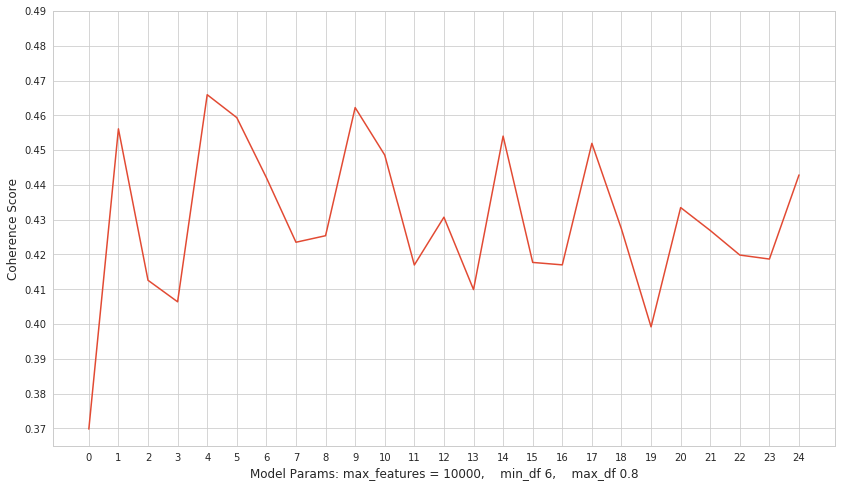

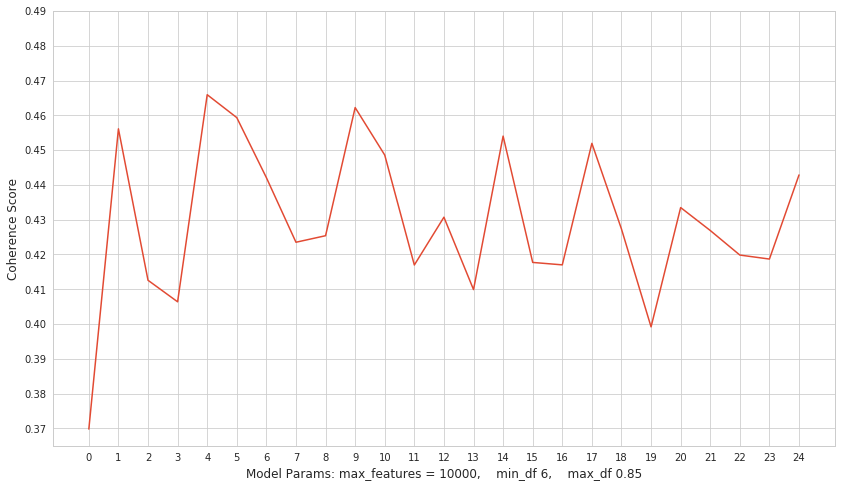

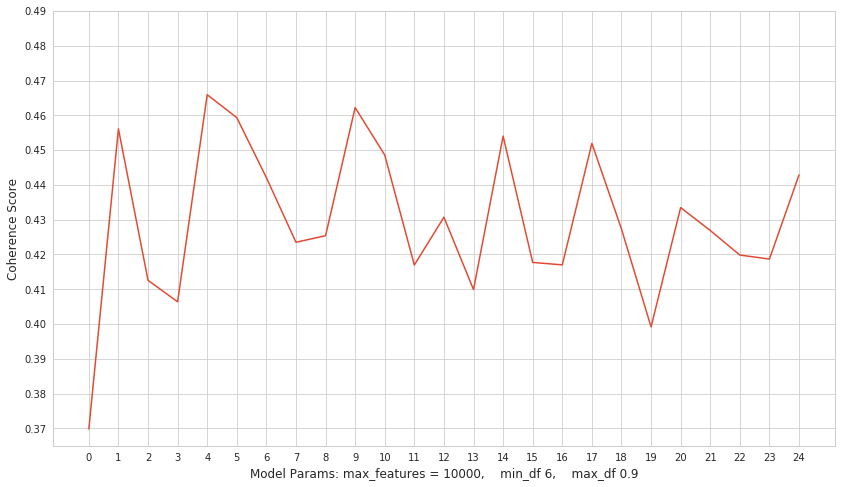

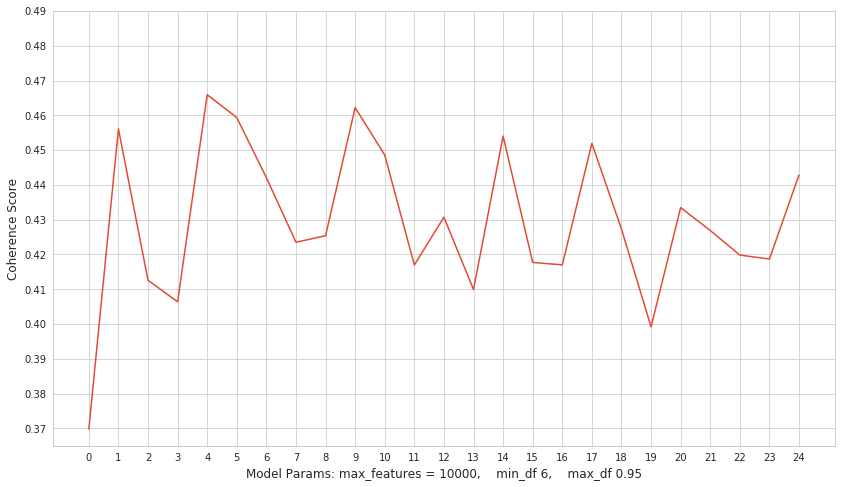

In [78]:
topic_modeler(10000, 6,.8,25, 1)
topic_modeler(10000, 6,.85,25, 1)
topic_modeler(10000, 6,.9,25, 1)
topic_modeler(10000, 6,.95,25, 1)

### Goals

- Coherence scoring
- topic selection / tuning
- review and inte
- product feature scoring (topics with coherence score)
- topic percentage contribution score
- coherence score improvement (parameter tuning)